# Solving a temperature-forecasting problem with GRUs

So far we've mainly discussed sequence data in the context of textual data, such as the IMDB dataset. However, sequence data is applicable to a wide range of problems beyond language processing. In the following examples, we'll look at a weather time series dataset collected at the weather station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

This dataset includes 14 different variables such as air temperature, air pressure, humidity, wind direction and others, recorded every 10 minutes over several years. While the original data go back to 2003, our focus here is on the data from 2009 to 2016. Our goal is to construct a model that takes recent historical data (a few days' worth of data points) as input and predicts the air temperature 24 hours into the future.

You can obtain and decompress the data using the following instructions:

In [ ]:
%%bash
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip

By the way, the following code is a modified version of the code that can be found in [1]. That said, let us begin by importing some useful libraries and modules.

In [39]:
import os
import numpy as np

from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.layers import Input
from keras.utils import timeseries_dataset_from_array
from keras.optimizers import RMSprop

The following lines of code will open the `csv` file that was downloaded and store that information in the variable named `data`.

In [40]:
data_dir = '/Users/dotero/Documents/TEC/Cursos/Bloque Integrador/MA3001B/Code/jena_climate'
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


We can see that we're working with 14 variables and 420,551 registers. In the following cell, we'll create two `NumPy` arrays: one for the temperature variable (`temperature`), and another one for all the data (`raw_data`).  

In [41]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Here is the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature.

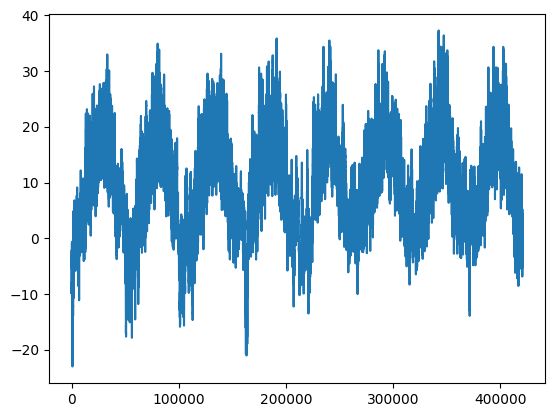

In [42]:
plt.plot(range(len(temperature)), temperature)

By the way, it is recommended that you always look for periodicity in your data. Time series data usually have periodicity on different time scales, so it's important to find these patterns so that the models we train can learn them.

In the next steps we'll allocate 50% of the data to training, 25% to validation and the remainder to testing. When dealing with time series data, it's important to ensure that the validation and test data sets are more recent than the training data. This is because our goal is to predict the future based on past observations, not to predict the past based on the future.

In [43]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Formulation of the problem

The problem we will be solving goes as follows: given data going as far back as `sequence_length` timesteps (a timestep is 10 minutes) and sampled every `sampling_rate` timesteps, can we predict the temperature in `delay` timesteps? We will use the following parameter values:

- `sequence_length`: 120—Observations will go back 5 days.
- `sampling_rate`: 6—Observations will be sampled at one data point per hour.
- `delay`: Targets will be 24 hours after the end of the sequence.

## Preparing the data

Each time series in the dataset operates on a different scale: for example, temperature typically ranges between -20 and +30, whereas atmospheric pressure, measured in mbar, hovers around 1,000. To deal with this, we'll normalize each time series independently, ensuring that they all have small values within a comparable scale.

In [44]:
mean = raw_data[: num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[: num_train_samples].std(axis=0)
raw_data /= std

Next, we'll construct a `dataset` object that produces batches of data over the past five days, along with a target temperature for 24 hours into the future.

As before, we could write a `Python` generator to do this, however, `Keras`  provides a handy built-in dataset utility (`timeseries_dataset_from_array()`). As expected, we'll use this utility to instantiate three datasets: one for training, one for validation, and one for testing.

In [45]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Every dataset provides a tuple (`samples`, `targets`), where samples represent a batch of 256 samples. Each `sample` comprises 120 consecutive hours of input data, while `targets` consist of the corresponding array of 256 target temperatures. It's important to note that the samples are shuffled randomly, meaning that two consecutive sequences in a batch (such as `samples[0]` and `samples[1]`) may not be temporally adjacent.

## A common-sense baseline

In this scenario, we can reasonably assume that the temperature timeseries is continuous (tomorrow's temperatures are expected to be similar to today's) and periodic, with a daily cycle. Therefore, a straightforward approach is to predict that the temperature 24 hours from now will be the same as the current temperature. We'll assess this method using the mean absolute error (MAE) metric.

In [46]:
def evaluate_naive_method(dataset):

    total_abs_err = 0.
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]

    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2025-04-08 07:14:24.711102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44
Test MAE: 2.62


2025-04-08 07:14:27.961612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This simple baseline results in a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. Therefore, predicting that the temperature 24 hours ahead will be identical to the current temperature leads to an average error of around two and a half degrees. This said, we'd expect our models to do better than this.  

## A first recurrent baseline

We'll experiment with a recurrent sequence processing model, which is ideal for the type of data we're working with.

We are going to use the GRU layer developed by Chung et al. in 2014. Gated Recurrent Unit (GRU) layers work on the same principle as LSTMs, but are more streamlined and therefore less computationally intensive (although they may not offer the same level of representational capacity as LSTMs). This trade-off between computational efficiency and representational capacity is a common consideration in various aspects of machine learning.

By the way, note that we'll be using the **mean absolute error**, also knows as **MAE**, as our evaluation metric. This is one of many choices for regression and forecasting applications.

In [47]:
model = Sequential()
model.add(Input(shape=(None, raw_data.shape[-1])))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(train_dataset, steps_per_epoch=40, epochs=20, validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - loss: 138.1079 - mae: 9.8067 - val_loss: 85.1489 - val_mae: 7.8094
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - loss: 71.9267 - mae: 6.9068 - val_loss: 48.9270 - val_mae: 5.4307
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - loss: 44.9167 - mae: 5.2149 - val_loss: 38.8976 - val_mae: 4.7817
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - loss: 35.9120 - mae: 4.5704 - val_loss: 30.0677 - val_mae: 4.0926
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - loss: 28.0409 - mae: 3.9614 - val_loss: 24.5007 - val_mae: 3.6789
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 22.4671 - mae: 3.5471 - val_loss: 20.0303 - val_mae: 3.3119
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - loss: 19.0290 - mae: 3.2645 - val_loss: 16.7348 - val_mae: 3.0257
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - loss: 16.1776 - mae: 3.0387 - val_loss: 14.7798 - val_mae: 2.8694
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━

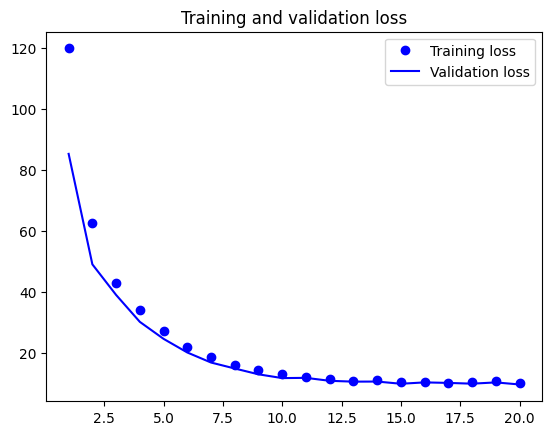

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The validation and test MAEs are 2.39 and 2.53, respectively, which means that we beat the common sense baseline. Furthermore, given the latter plot, we do not have overfitting. 

We seem to be on track, but we have a little room for improvement.

## Using recurrent dropout to fight overfitting

Even though we have little overfitting, it is worth saying a few words about a technique we can use to combat this problem: dropout, which randomly deactivates input units of a layer to break any random correlations in the training data that the layer might be learning. However, correctly applying dropout in recurrent networks is a non-trivial challenge. It's long been known that applying dropout before a recurrent layer can actually hinder learning, rather than help with regularization.

In 2015, as part of her Ph.D. thesis on Bayesian deep learning, Yarin Gal established the correct method for employing dropout in recurrent networks: applying the same dropout mask (i.e., the same pattern of deactivated units) at every timestep, rather than using a randomly varying dropout mask from timestep to timestep. Furthermore, to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally consistent dropout mask should be applied to the inner recurrent activations of the layer (known as recurrent dropout). Using the same dropout mask at each time step allows the network to effectively propagate its learning errors over time, whereas a temporally random dropout mask would disrupt this error signal and hinder the learning process.

In [50]:
model = Sequential()
model.add(Input(shape=(None, raw_data.shape[-1])))
model.add(layers.GRU(32, recurrent_dropout=0.1))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                    │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(train_dataset, steps_per_epoch=40, epochs=20, validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 2413.3389 - mae: 12.0565 - val_loss: 166.1797 - val_mae: 10.7611
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - loss: 158.4922 - mae: 10.4518 - val_loss: 164.0312 - val_mae: 10.6961
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - loss: 152.4790 - mae: 10.2738 - val_loss: 157.9491 - val_mae: 10.5152
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 467.0931 - mae: 10.2738 - val_loss: 146.5751 - val_mae: 10.1667
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - loss: 138.0194 - mae: 9.7048 - val_loss: 144.2551 - val_mae: 10.0959
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - loss: 130.0432 - mae: 9.5463 - val_loss: 140.3488 - val_mae: 9.9707
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - loss: 124.3871 - mae: 9.3302 - val_loss: 130.7911 - val_mae: 9.6632
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - loss: 173.4144 - mae: 9.1675 - val_loss: 125.1786 - val_mae: 9.4704
Epoch 

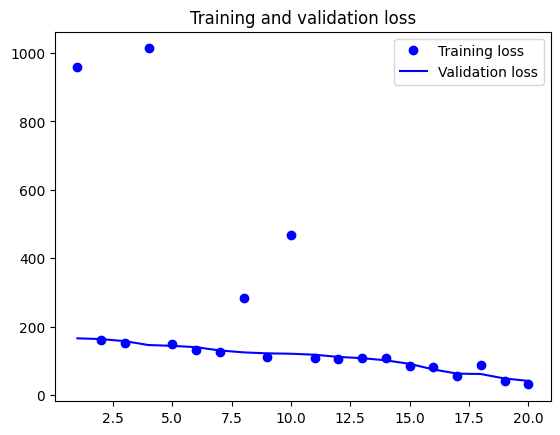

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We do not have overfitting, but the results are not as good as the previous ones. 

## Stacking recurrent layers

We are now facing a performance bottleneck, so it may be beneficial to increase the capacity of the network. Remember the universal machine learning workflow, which suggests increasing network capacity until overfitting becomes the main challenge (assuming you're already using basic techniques like dropout to mitigate overfitting). If you're not struggling with severe overfitting, it's likely that the network is under-capacity.

Increasing the capacity of the network usually involves adding more units to the layers or adding additional layers. A classic way to create more powerful recurrent networks is to stack recurrent layers.

In Keras, to stack recurrent layers, all intermediate layers should return their full sequence of outputs (a 3D tensor), rather than just the output at the last timestep. This can be done by setting `return_sequences=True`.

In [53]:
model = Sequential()
model.add(Input(shape=(None, raw_data.shape[-1])))
model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, None, 32)       │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,489 (91.75 KB)

 Trainable params: 23,489 (91.75 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = model.fit(train_dataset, steps_per_epoch=40, epochs=20, validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 779ms/step - loss: 103.9292 - mae: 8.1227 - val_loss: 18.2430 - val_mae: 3.3887
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 788ms/step - loss: 19.9243 - mae: 3.5333 - val_loss: 12.0648 - val_mae: 2.7449
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 791ms/step - loss: 13.7511 - mae: 2.9418 - val_loss: 10.4837 - val_mae: 2.5454
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 708ms/step - loss: 11.9036 - mae: 2.7174 - val_loss: 9.8711 - val_mae: 2.4544
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 826ms/step - loss: 11.3166 - mae: 2.6587 - val_loss: 12.1277 - val_mae: 2.7379
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 732ms/step - loss: 11.3975 - mae: 2.6537 - val_loss: 9.9523 - val_mae: 2.4599
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 10.4332 - mae: 2.5306 - val_loss: 9.7251 - val_mae: 2.4277
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 940s 24s/step - loss: 10.7499 - mae: 2.5818 - val_loss: 9.3683 - val_mae: 2.3837
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1

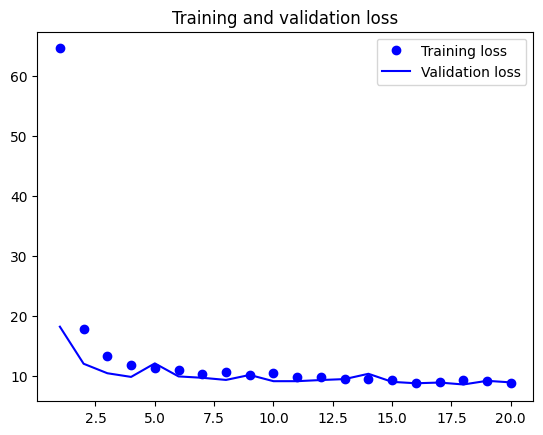

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The inclusion of an additional layer leads to a slight improvement in the results: the validation and test MAEs are 2.32 and 2.46, respectively. Two important points can be derived from this:

- Since we still don't experience severe overfitting, there is room to increase the size of the layers to improve the validation loss. However, this comes with a significant increase in computational complexity.

- The addition of another layer did not result in a significant improvement, suggesting that we may encounter diminishing returns from further increasing the capacity of the network at this stage.

## References

[1] Chollet, Francois. *Deep learning with Python*. Simon and Schuster, 2021.